# 03_Component2_Gap_Analysis.ipynb


## 1. Environment Setup & Imports


In [13]:
## 1. Environment Setup & Imports

import pandas as pd
import numpy as np
import nltk
import torch
from transformers import pipeline, AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import json
from joblib import load, dump

# Styling
sns.set(style="whitegrid")

# Download NLTK data (once)
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\piyum\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\piyum\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 2. Load Data & Models


In [24]:
# 03_Component2_Gap_Analysis_TFIDF.ipynb

## 1. Environment Setup & Imports

import pandas as pd
import numpy as np
import nltk

# Sentiment
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Tokenization
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

# TF-IDF & similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
from joblib import load, dump

# Styling
sns.set(style="whitegrid")

# Download required NLTK data (run once)
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('stopwords')


## 2. Load Data & Prepare Resources

# 2.1 Preprocessed feedback
df = pd.read_excel("cleaned_feedback_preprocessed.xlsx")

# 2.2 Inline Aspect Ontology
# 2.2 Expanded Inline Aspect Ontology

ontology = {
    # -------------------------------------------------
    # 1. Mentorship & Guidance
    # -------------------------------------------------
    "mentorship": [
        "mentor", "supervisor", "coach", "guide", "mentorship",
        "advice", "feedback", "direction", "support", "one_on_one",
        "pair_programming", "shadowing", "check_in", "guidance",
        "tutoring", "oversight", "counsel", "help", "assistance"
    ],

    # -------------------------------------------------
    # 2. Technical Support & Tools
    # -------------------------------------------------
    "technical_support": [
        "code", "review", "debug", "assistance", "support", "ci_cd",
        "repository", "git", "docker", "kubernetes", "jenkins",
        "documentation", "sdk", "api", "integration", "toolchain",
        "ide", "environment", "software", "hardware", "access",
        "credentials", "infrastructure", "setup", "deployment"
    ],

    # -------------------------------------------------
    # 3. Learning Opportunities & Training
    # -------------------------------------------------
    "learning_opportunities": [
        "training", "workshop", "tutorial", "learning", "session",
        "seminar", "course", "webinar", "onboarding", "bootcamp",
        "hands_on", "self_learning", "upskill", "knowledge",
        "skill_building", "certification", "lecture", "e_learning",
        "demo", "example", "exercise"
    ],

    # -------------------------------------------------
    # 4. Workload & Assignments
    # -------------------------------------------------
    "workload": [
        "task", "deadline", "hours", "workload", "assignment",
        "responsibility", "project", "deliverable", "milestone",
        "time_management", "overtime", "pace", "throughput",
        "capacity", "effort", "busy", "overwhelmed", "underutilized"
    ],

    # -------------------------------------------------
    # 5. Team Collaboration & Communication
    # -------------------------------------------------
    "team_collaboration": [
        "team", "communication", "meeting", "collaboration", "scrum",
        "stand_up", "pairing", "brainstorm", "discussion",
        "feedback_loop", "mail", "chat", "slack", "jira", "confluence",
        "cross_functional", "peer_review", "coordination",
        "rapport", "interaction"
    ],

    # -------------------------------------------------
    # 6. Workplace Environment & Culture
    # -------------------------------------------------
    "environment": [
        "workspace", "tools", "software", "hardware", "remote",
        "office", "infrastructure", "ergonomics", "culture",
        "atmosphere", "facilities", "amenities", "environment",
        "comfort", "noise", "lighting", "temperature", "space",
        "cleanliness", "accessibility"
    ],

    # -------------------------------------------------
    # 7. Professional Networking & Culture
    # -------------------------------------------------
    "professional_networking": [
        "networking", "event", "culture", "social", "interaction",
        "community", "connections", "coffee_chat", "lunch",
        "networking_event", "career_fair", "meetup", "seminar",
        "conference", "alumni", "exposure", "company_culture",
        "diversity", "inclusion", "team_building"
    ],

    # -------------------------------------------------
    # 8. Career Guidance & Advancement
    # -------------------------------------------------
    "career_guidance": [
        "career", "path", "feedback", "evaluation", "progression",
        "review", "promotion", "opportunity", "growth",
        "performance_review", "advancement", "goals", "milestones",
        "future", "trajectory", "mentorship", "coaching",
        "job_offer", "interview", "resume_building"
    ]
}

aspect_categories = list(ontology.keys())

# 2.3 Sentiment analyzer
sid = SentimentIntensityAnalyzer()

# 2.4 Stopwords for token filtering
stop_words = set(stopwords.words('english'))
# (Add any domain‐specific stopwords if desired)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\piyum\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\piyum\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\piyum\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 3. Helper Functions


In [25]:
## 3. Helper Functions (Regex‐based tokenization and VADER sentiment)

import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# initialize sentiment analyzer
sid = SentimentIntensityAnalyzer()

def split_sentences(text: str) -> list[str]:
    """
    Split text on sentence delimiters (., !, ?) or line breaks.
    Returns non-empty trimmed segments.
    """
    if not isinstance(text, str):
        return []
    parts = re.split(r'(?<=[\.\!\?])\s+|\n+', text)
    return [p.strip() for p in parts if p.strip()]

def classify_sentence_type(sent: str) -> str:
    """
    Classify a sentence as:
      - "expect" if it mentions expectation keywords,
      - "experience" if it mentions experience keywords,
      - "other" otherwise.
    """
    s = sent.lower()
    if re.search(r'\b(expect|hope|plan|anticipat|want(ed)?|intend)\b', s):
        return "expect"
    if re.search(r'\b(found|was|experienced|learned|got|felt|realized|saw)\b', s):
        return "experience"
    return "other"

def map_aspects(sent: str) -> list[str]:
    """
    Return list of aspect categories whose lexicon terms appear in the sentence.
    Tokenization via regex; matches whole words only.
    """
    if not isinstance(sent, str):
        return []
    tokens = re.findall(r'\b[a-zA-Z_]+\b', sent.lower())
    cats = []
    for aspect, terms in ontology.items():
        for term in terms:
            # allow multi-word terms by splitting on underscore
            for token in tokens:
                if term in token or token in term:
                    cats.append(aspect)
                    break
            else:
                continue
            break
    return cats

def sentiment_polarity(sent: str) -> int:
    """
    Compute VADER compound score and map to {-1, 0, +1}.
    """
    if not isinstance(sent, str):
        return 0
    score = sid.polarity_scores(sent).get("compound", 0.0)
    if score >=  0.05:
        return  1
    if score <= -0.05:
        return -1
    return 0


## 4. Build Expectation & Experience Sets


In [27]:
## 4. Build Expectation & Experience Records

import pandas as pd

# 4.1 Auto‐detect the main feedback column by average string length
string_cols = df.select_dtypes(include='object').columns
avg_lengths = (
    df[string_cols]
    .fillna("")
    .astype(str)
    .applymap(len)
    .mean()
)
text_col = avg_lengths.idxmax()
print(f"Using `{text_col}` as the feedback text column.\n")

# 4.2 Build the records list
records = []
for idx, text in df[text_col].fillna("").astype(str).items():
    # split into sentences
    for sent in split_sentences(text):
        sent_type = classify_sentence_type(sent)
        if sent_type == "other":
            continue
        cats = map_aspects(sent)
        if not cats:
            continue
        pol = sentiment_polarity(sent)

        # one record per aspect for easier aggregation later
        for asp in cats:
            records.append({
                "id": idx,
                "sentence": sent,
                "sent_type": sent_type,
                "aspect": asp,
                "polarity": pol
            })

gap_df = pd.DataFrame(records)

# 4.3 Inspect results
print("Sentence type counts:\n", gap_df["sent_type"].value_counts())
print("\nAspect distribution:\n", gap_df["aspect"].value_counts())
print("\nColumns in gap_df:", gap_df.columns.tolist())

# 4.4 Save the gap DataFrame for downstream use
gap_df.to_excel("gap_analysis_records.xlsx", index=False)
print("Saved detailed gap records to gap_analysis_records.xlsx")


Using `overall_comment_about_the_industrial_training` as the feedback text column.

Sentence type counts:
 sent_type
experience    608
expect         78
Name: count, dtype: int64

Aspect distribution:
 aspect
learning_opportunities     91
technical_support          87
team_collaboration         87
environment                86
career_guidance            85
workload                   85
mentorship                 83
professional_networking    82
Name: count, dtype: int64

Columns in gap_df: ['id', 'sentence', 'sent_type', 'aspect', 'polarity']
Saved detailed gap records to gap_analysis_records.xlsx


C:\Users\piyum\AppData\Local\Temp\ipykernel_16176\1595237654.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[string_cols]


## 5. Compute Per-Aspect Metrics per Intern


In [29]:
## 5. Compute Per-Aspect Discrepancy Metrics (TF–IDF + Sentiment)

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 5.1 Fit TF-IDF on all extracted sentences
tfidf = TfidfVectorizer()
tfidf.fit(gap_df['sentence'])

res = []
alpha = 0.6  # weight for semantic vs. sentiment

for idx, grp in gap_df.groupby('id'):
    # overall satisfaction if available
    overall = df.at[idx, 'overall_satisfaction'] if 'overall_satisfaction' in df.columns else np.nan

    for aspect in aspect_categories:
        # filter records for this aspect
        sub = grp[grp['aspect'] == aspect]

        # 5.2 Expectation sentences
        exp_sents = sub[sub['sent_type'] == 'expect']['sentence'].tolist()
        if exp_sents:
            exp_mat = tfidf.transform(exp_sents)
            exp_cent = np.asarray(exp_mat.mean(axis=0)).ravel()
            exp_pol = sub[sub['sent_type'] == 'expect']['polarity'].mean()
        else:
            exp_cent = np.zeros(tfidf.transform(['']).shape[1])
            exp_pol = 0.0

        # 5.3 Experience sentences
        xp_sents = sub[sub['sent_type'] == 'experience']['sentence'].tolist()
        if xp_sents:
            xp_mat = tfidf.transform(xp_sents)
            xp_cent = np.asarray(xp_mat.mean(axis=0)).ravel()
            xp_pol = sub[sub['sent_type'] == 'experience']['polarity'].mean()
        else:
            xp_cent = np.zeros(tfidf.transform(['']).shape[1])
            xp_pol = 0.0

        # 5.4 Semantic gap
        sim = cosine_similarity([exp_cent], [xp_cent])[0, 0]
        sem_gap = 1 - sim

        # 5.5 Sentiment gap
        sent_gap = xp_pol - exp_pol

        # 5.6 Hybrid gap
        hyb_gap = alpha * sem_gap + (1 - alpha) * abs(sent_gap)

        res.append({
            'id': idx,
            'aspect': aspect,
            'exp_mean_polarity': exp_pol,
            'xp_mean_polarity': xp_pol,
            'semantic_gap': sem_gap,
            'sentiment_gap': sent_gap,
            'hybrid_gap': hyb_gap,
            'overall_satisfaction': overall
        })

metrics_df = pd.DataFrame(res)

# 5.7 Inspect the top rows
print(metrics_df.head())

# 5.8 Save metrics to Excel
metrics_df.to_excel("gap_analysis_metrics_tfidf.xlsx", index=False)
print("Saved per-aspect discrepancy metrics to gap_analysis_metrics_tfidf.xlsx")


   id                  aspect  exp_mean_polarity  xp_mean_polarity  \
0   4              mentorship                0.0               0.0   
1   4       technical_support                0.0               0.0   
2   4  learning_opportunities                0.0               1.0   
3   4                workload                0.0               1.0   
4   4      team_collaboration                0.0               0.0   

   semantic_gap  sentiment_gap  hybrid_gap  overall_satisfaction  
0           1.0            0.0         0.6                   NaN  
1           1.0            0.0         0.6                   NaN  
2           1.0            1.0         1.0                   NaN  
3           1.0            1.0         1.0                   NaN  
4           1.0            0.0         0.6                   NaN  
Saved per-aspect discrepancy metrics to gap_analysis_metrics_tfidf.xlsx


## 6. Visualizations


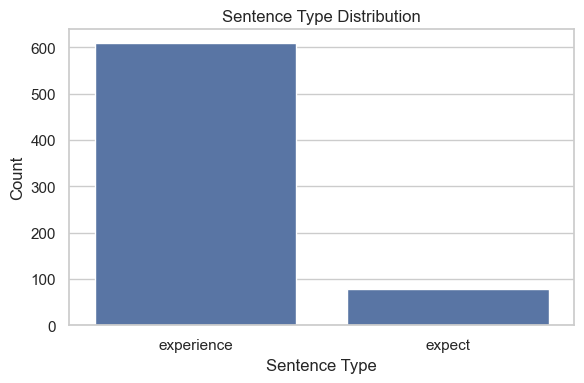

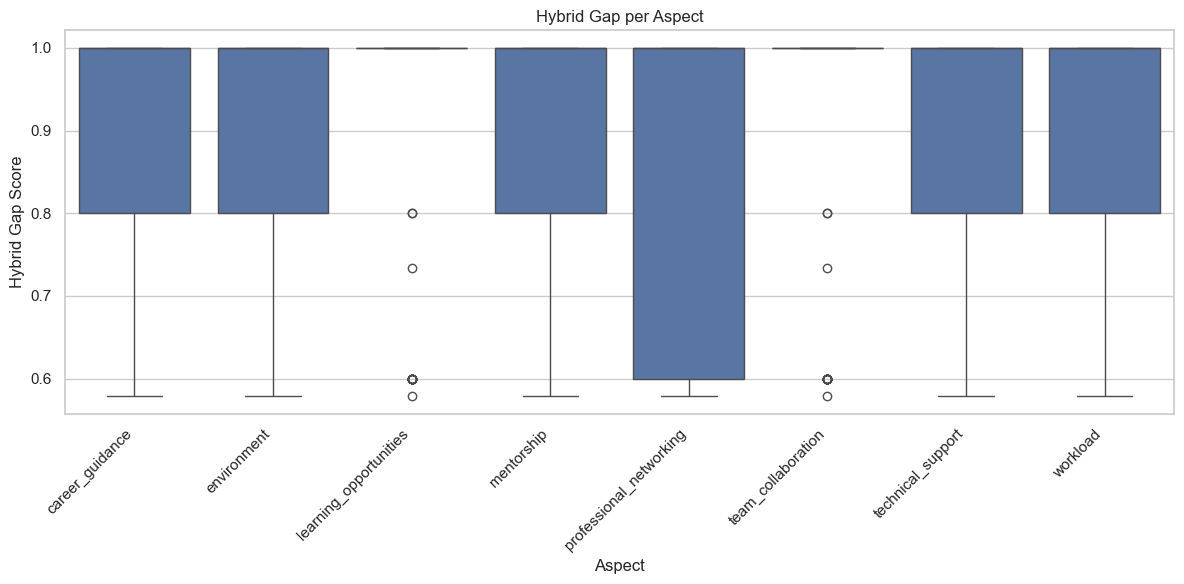

Pearson correlation (overall_satisfaction vs. hybrid_gap): nan


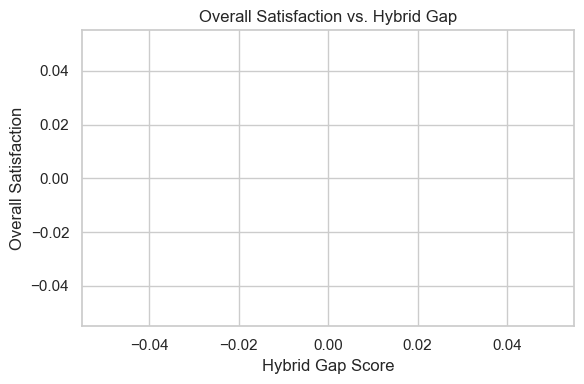

In [30]:
# 6. Visualizations & Save Plots

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 6.1 Sentence Type Distribution
plt.figure(figsize=(6, 4))
order = gap_df['sent_type'].value_counts().index
ax = sns.countplot(x='sent_type', data=gap_df, order=order)
ax.set_title("Sentence Type Distribution")
ax.set_xlabel("Sentence Type")
ax.set_ylabel("Count")
plt.tight_layout()
plt.savefig("sentence_type_distribution.png", dpi=300)
plt.show()

# 6.2 Hybrid Gap Boxplot per Aspect
plt.figure(figsize=(12, 6))
aspect_order = metrics_df.groupby('aspect')['hybrid_gap'].median().sort_values().index
ax = sns.boxplot(
    x='aspect',
    y='hybrid_gap',
    data=metrics_df,
    order=aspect_order
)
ax.set_title("Hybrid Gap per Aspect")
ax.set_xlabel("Aspect")
ax.set_ylabel("Hybrid Gap Score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("hybrid_gap_per_aspect.png", dpi=300)
plt.show()

# 6.3 Correlation Between Overall Satisfaction and Hybrid Gap
if 'overall_satisfaction' in metrics_df.columns:
    corr = metrics_df['hybrid_gap'].corr(metrics_df['overall_satisfaction'])
    print(f"Pearson correlation (overall_satisfaction vs. hybrid_gap): {corr:.2f}")

    plt.figure(figsize=(6, 4))
    ax = sns.scatterplot(
        x='hybrid_gap',
        y='overall_satisfaction',
        data=metrics_df,
        alpha=0.4
    )
    ax.set_title("Overall Satisfaction vs. Hybrid Gap")
    ax.set_xlabel("Hybrid Gap Score")
    ax.set_ylabel("Overall Satisfaction")
    plt.tight_layout()
    plt.savefig("satisfaction_vs_hybrid_gap.png", dpi=300)
    plt.show()
else:
    print("Column 'overall_satisfaction' not found in metrics_df.")


## 7. Save Metrics & Models


In [31]:
# save results
metrics_df.to_excel("gap_analysis_metrics.xlsx", index=True)
# (optional) save alpha for later
dump(alpha, "models/hybrid_gap_alpha.joblib")


['models/hybrid_gap_alpha.joblib']